# Set-up

In [1]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import surrojax_gp
import sys
sys.path.insert(0, '..')
import plotting_helpers

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 100
# dpi of images saved to seperate folder:
mpl_save_dpi = 300

Plotting function:

In [52]:
def plot_surface(x, y, z, z_lims, num_x_ticks=10, num_y_ticks=10, num_z_ticks=10, z_ticks_dp=1):
    fig, ax = plt.subplots()
    im = plt.imshow(z, cmap='coolwarm', origin='lower')
    plotting_helpers.set_x_and_y_ticks(ax, x, y, num_x_ticks, num_y_ticks)
    plotting_helpers.create_colourbar(im, '$z$', z_lims, num_z_ticks, z_ticks_dp)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plotting_helpers.clean_up_plot(fig)

Function to differentiate and vmap:

In [28]:
def grad_and_vmap(func, args):
    grad = func
    for arg in args:
        grad = jax.jacfwd(grad, argnums=arg)
    for _ in range(2):
        grad = jax.vmap(grad, in_axes=(0,0))
    return grad    

# Verification

Function to learn:

In [3]:
# Peak function (see: https://mathworks.com/help/matlab/ref/peaks.html)
def peaks(x, y):
    first_term = 3*(1-x)**2*jnp.exp(-x**2-(y+1)**2)
    second_term = -10*(x/5 - x**3 - y**5)*jnp.exp(-x**2-y**2)
    third_term = -1/3*jnp.exp(-(x+1)**2-y**2)
    return first_term + second_term + third_term

Kernel:

In [4]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

Plot 'true' function:

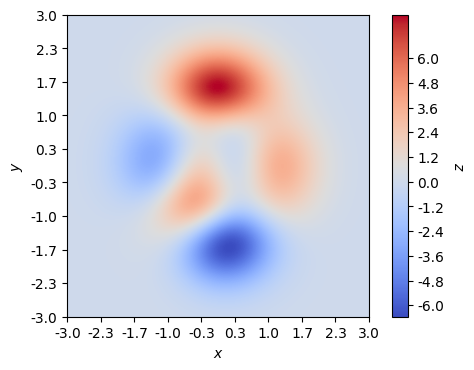

In [54]:
num_pts = 1000
x_vals = jnp.linspace(-3, 3, num_pts)
y_vals = jnp.linspace(-3, 3, num_pts)
x, y = jnp.meshgrid(x_vals, y_vals)
z = peaks(x,y)
plot_surface(x, y, z, z_lims=(-6,6))

Create 'training' data:

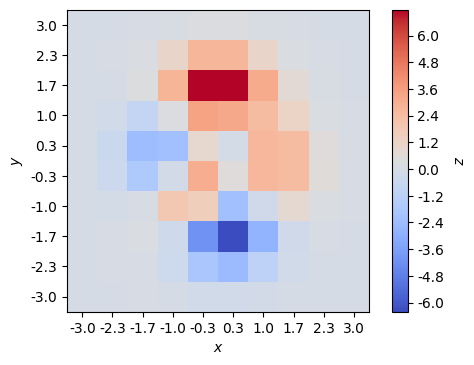

In [53]:
num_train_pts = 10
x_vals = jnp.linspace(-3, 3, num_train_pts)
y_vals = jnp.linspace(-3, 3, num_train_pts)
x_train, y_train = jnp.meshgrid(x_vals, y_vals)
z_train = peaks(x_train,y_train)
plot_surface(x_train, y_train, z_train, z_lims=(-6,6))

Train GP:

In [9]:
constraints = {"length_0": {">": 0.01, "<": 10}, 
               "length_1": {">": 0.01, "<": 10}, 
               "const": {">": 0.01, "<": 10}}
train_features = jnp.stack([x_train.flatten(), y_train.flatten()], axis=1)
train_labels = z_train.flatten()
gp = surrojax_gp.create_gp(kernel, train_features, train_labels, constraints)

1572729.8
222.28546
222.28522
222.28427
222.2803
222.26459
222.20166
221.94748
220.20721
203.6496
426.0506
178.8489
174.92578
174.0438
173.81674
145.66972
15992.808
128.13017
126.68078
124.73407
124.062515
60131.848
147.86214
123.57526
6593.535
142.08737
121.19119
152.7268
120.41073
120.04833
119.91779
119.891556
119.89023
119.89045
119.89015
119.890175
119.89015
119.89029
119.890076
119.890564
119.890076
119.89049
119.89
119.88994
119.890594
119.8902
119.88994
119.88994
119.8903
119.88994
119.89063
119.89026
119.89019
119.88994
119.88994
119.89043
119.88994
119.88994
119.8902
119.88994
119.88994
119.890175
119.88994
119.88994
119.89
119.88994
119.88994
119.88994
119.88994
119.88994
122.98245
119.8905
119.89019
119.88994
119.88994
119.89012
119.88994
119.88994
119.890274
119.88994
119.88994
119.88994
119.88994
119.88994
119.88994
119.88994
119.88994
119.88994
119.88994
119.88994
      fun: array(119.88993835)
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.

GP evaluated at training points:

In [55]:
features = jnp.stack([x.flatten(), y.flatten()], axis=1)
z_pred = gp.predict(train_freatures)['mean'].reshape(num_pts, num_pts)
plot_surface(x_train, y_train, z_pred, z_lims=(-6,6))

NameError: name 'train_freatures' is not defined

# Gradient Predictions

In [ ]:
features = jnp.stack([x.flatten(), y.flatten()], axis=1)

Gradient wrt x:

In [33]:
gp_dx = gp.predict(features, grad=({'idx':[0], 'order':1},))['mean'].reshape(num_pts,num_pts)
true_dx = grad_and_vmap(peaks, args=(0,))(x,y).reshape(num_pts,num_pts)

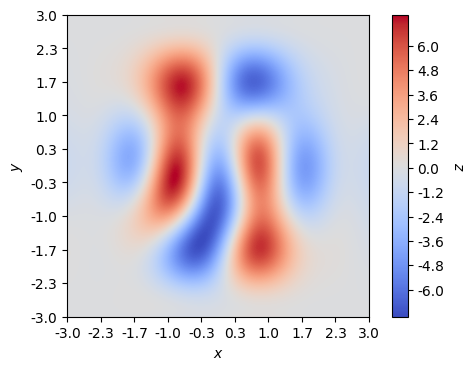

In [56]:
plot_surface(x, y, gp_dx, z_lims=(-6,6))

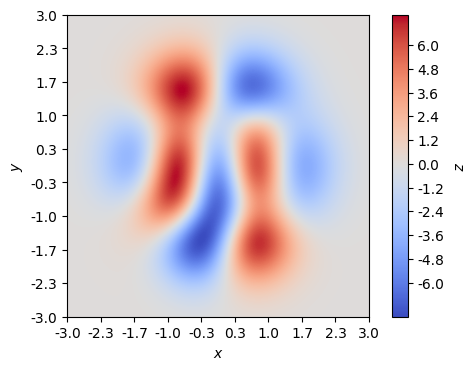

In [57]:
plot_surface(x, y, true_dx, z_lims=(-6,6))

Gradient wrt y:

In [38]:
gp_dy = gp.predict(features, grad=({'idx':[1], 'order':1},))['mean'].reshape(num_pts,num_pts)
true_dy = grad_and_vmap(peaks, args=(1,))(x,y).reshape(num_pts,num_pts)

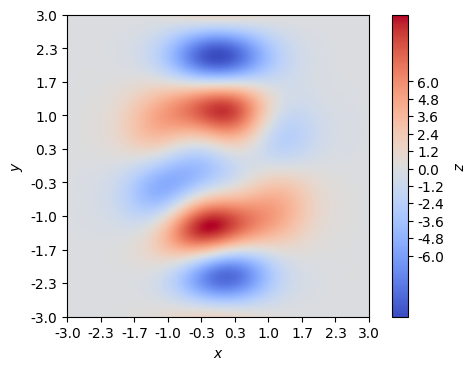

In [59]:
plot_surface(x, y, gp_dy, z_lims=(-6,6))

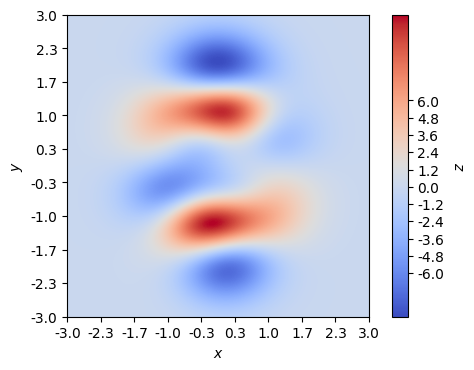

In [58]:
plot_surface(x, y, true_dy, z_lims=(-6,6))

Mixed gradient wrt x and y:

In [43]:
gp_dxdy = gp.predict(features, grad=({'idx':[0], 'order':1},{'idx':[1], 'order':1}))['mean'].reshape(num_pts,num_pts)
true_dxdy = grad_and_vmap(peaks, args=(0,1))(x,y).reshape(num_pts,num_pts)

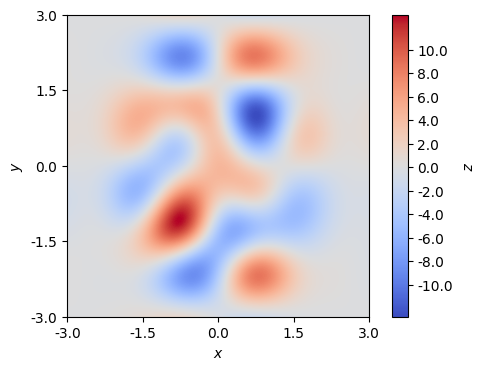

In [44]:
plot_surface(x, y, gp_dxdy, z_lims=(-6,6))

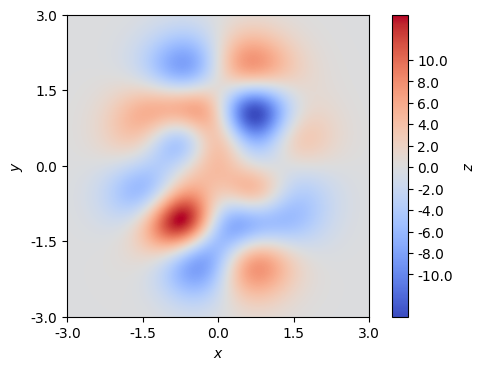

In [45]:
plot_surface(x, y, true_dxdy, z_lims=(-6,6))

Double gradient wrt x:

In [60]:
gp_dxdx = gp.predict(features, grad=({'idx':[0], 'order':1},{'idx':[0], 'order':1}))['mean'].reshape(num_pts,num_pts)
true_dxdx = grad_and_vmap(peaks, args=(0,0))(x,y).reshape(num_pts,num_pts)

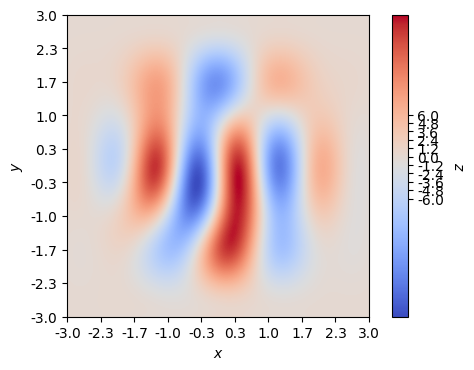

In [61]:
plot_surface(x, y, gp_dxdx, z_lims=(-6,6))

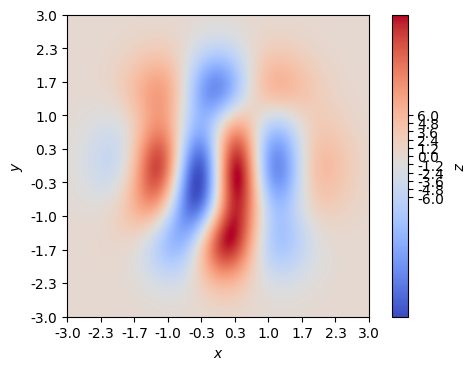

In [62]:
plot_surface(x, y, true_dxdx, z_lims=(-6,6))